In [9]:
from pymongo import MongoClient
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

In [10]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [11]:
# confirm that our new database was created
print(mongo.list_database_names())

['Ca_Fires', 'Cali_Fires', 'admin', 'autosaurus', 'classDB', 'config', 'epa', 'local', 'met', 'petsitly_marketing', 'travel_db', 'uk_food']


In [12]:
# assign the database to a variable name
fire_db = mongo['Cali_Fires']


In [13]:
# review the collections in our new database
print(fire_db.list_collection_names())

['2000_2022']


In [19]:
#assign the collection to a variable

fires = fire_db['2000_2022']

In [20]:
# review a document in the collection
print(fire_db['2000_2022'].find_one())

{'_id': ObjectId('65caf116fa3430cdba0deb75'), 'OBJECTID': 21440, 'YEAR_': 2020, 'STATE': 'CA', 'FIRE_NAME': 'NELSON', 'GIS_ACRES': 109.60228}


In [21]:
# build the aggregation pipeline

match_query = {'$match': {'YEAR_': {'$gte': 2000, '$lt': 2022}}}

sort_values = {'$sort': {'count': -1}}

pipeline = [match_query, sort_values]


In [23]:
# run the pipeline cast as list and save to a variable
results = list(fires.aggregate(pipeline))

In [24]:
# print the number of rows
print(len(results))

7225


In [25]:
#print first 10 results
pprint(results[0:10])

[{'FIRE_NAME': 'NELSON',
  'GIS_ACRES': 109.60228,
  'OBJECTID': 21440,
  'STATE': 'CA',
  'YEAR_': 2020,
  '_id': ObjectId('65caf116fa3430cdba0deb75')},
 {'FIRE_NAME': 'AMORUSO',
  'GIS_ACRES': 685.58502,
  'OBJECTID': 21441,
  'STATE': 'CA',
  'YEAR_': 2020,
  '_id': ObjectId('65caf116fa3430cdba0deb76')},
 {'FIRE_NAME': 'ATHENS',
  'GIS_ACRES': 27.30048,
  'OBJECTID': 21442,
  'STATE': 'CA',
  'YEAR_': 2020,
  '_id': ObjectId('65caf116fa3430cdba0deb77')},
 {'FIRE_NAME': 'FLEMING',
  'GIS_ACRES': 12.931545,
  'OBJECTID': 21443,
  'STATE': 'CA',
  'YEAR_': 2020,
  '_id': ObjectId('65caf116fa3430cdba0deb78')},
 {'FIRE_NAME': 'MELANESE',
  'GIS_ACRES': 10.315964,
  'OBJECTID': 21444,
  'STATE': 'CA',
  'YEAR_': 2020,
  '_id': ObjectId('65caf116fa3430cdba0deb79')},
 {'FIRE_NAME': 'PFE',
  'GIS_ACRES': 36.701931,
  'OBJECTID': 21445,
  'STATE': 'CA',
  'YEAR_': 2020,
  '_id': ObjectId('65caf116fa3430cdba0deb7a')},
 {'FIRE_NAME': 'VALLEY',
  'GIS_ACRES': 376.9104,
  'OBJECTID': 21446,
  'ST

In [33]:
# save to dataframe
Ca_df = pd.json_normalize(results)
# drop unwanted columns
columns_to_drop = ['OBJECTID', '_id']
Ca_df.drop(columns=columns_to_drop, inplace=True)
# print results
Ca_df.head()

,YEAR_,STATE,FIRE_NAME,GIS_ACRES
0,2020,CA,NELSON,109.602280
1,2020,CA,AMORUSO,685.585020
2,2020,CA,ATHENS,27.300480
3,2020,CA,FLEMING,12.931545
4,2020,CA,MELANESE,10.315964


In [34]:
# rename columns

Ca_df = Ca_df.rename(columns={'YEAR_': 'Year',
                             'GIS_ACRES': 'Acres_Burned',
                             'STATE': 'State',
                             'FIRE_NAME': 'Fire_Name'})
# print new columns
Ca_df.head(10)

,Year,State,Fire_Name,Acres_Burned
0,2020,CA,NELSON,109.602280
1,2020,CA,AMORUSO,685.585020
2,2020,CA,ATHENS,27.300480
3,2020,CA,FLEMING,12.931545
4,2020,CA,MELANESE,10.315964
5,2020,CA,PFE,36.701931
6,2020,CA,VALLEY,376.910400
7,2020,CA,WALDO,10.102212
8,2020,CA,WILLOW,33.973888
9,2020,CA,WILLOWS,1309.090000


In [37]:
max_acres = Ca_df.groupby('Year')['Acres_Burned'].max()
max_acres

Year
2000      79223.430
2001      34218.848
2002     501082.030
2003     270686.000
2004      38763.016
2005      63771.406
2006     161815.660
2007     240358.700
2008     163606.690
2009     160833.110
2010      16448.225
2011      25939.012
2012     315511.500
2013     256175.530
2014     133177.380
2015     151546.810
2016     132104.280
2017     281790.880
2018     410202.470
2019      77762.141
2020    1032699.600
2021     963405.440
Name: Acres_Burned, dtype: float64

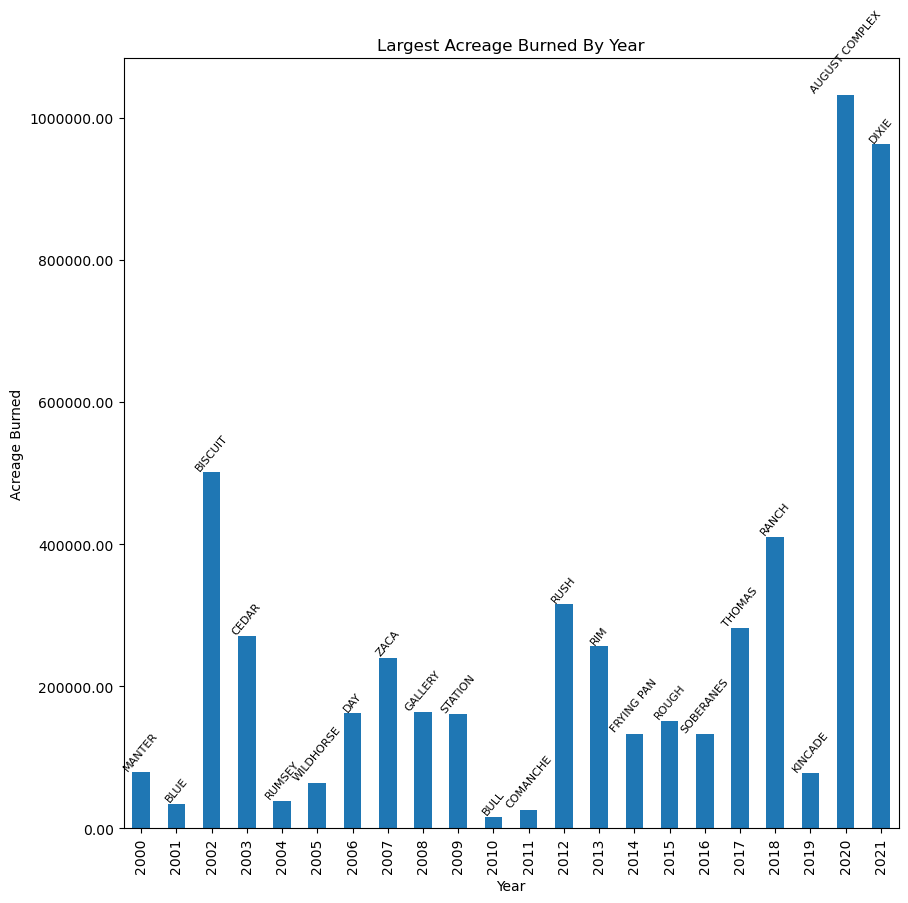

In [78]:
# plot the results as a graph

ax = max_acres.plot(kind= 'bar',
          y= 'Acres_Burned',
          x= 'Fire_Name',
          title= 'Largest Acreage Burned By Year',
          figsize=(10,10))
# Adjusting y-axis tick formatting to display decimals
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

# Annotating each bar with the fire name
for i, (year, acreage) in enumerate(max_acres.items()):
    fire_name = Ca_df.loc[Ca_df['Acres_Burned'] == acreage, 'Fire_Name'].iloc[0]
    ax.text(i, acreage + 0.1, f"{fire_name}", ha='center', va='bottom', rotation=50, fontsize=8)
plt.ylabel('Acreage Burned')
plt.savefig('Resources/Fire_Bar_Graph.png')
plt.show()

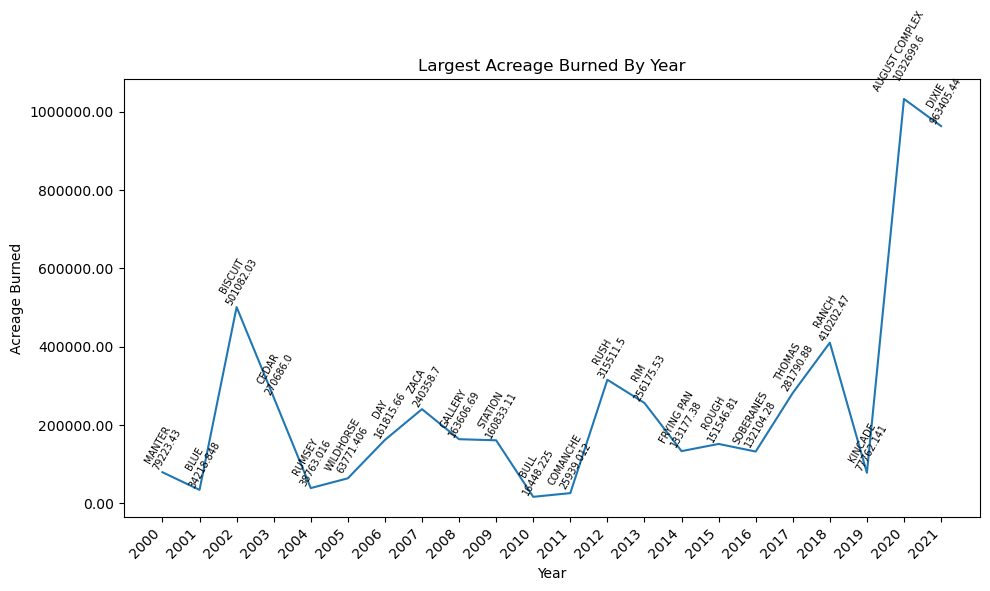

In [79]:

# Create a line plot
ax = max_acres.plot(kind='line', title='Largest Acreage Burned By Year', figsize=(10, 6))
plt.ylabel('Acreage Burned')
plt.xlabel('Year')

# Adjusting y-axis tick formatting to display decimals
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

# Annotating each point on the line with the fire name and acreage burned
for i, (year, acreage) in enumerate(max_acres.items()):
    fire_name = Ca_df.loc[Ca_df['Acres_Burned'] == acreage, 'Fire_Name'].iloc[0]
    ax.text(year, acreage + 0.1, f"{fire_name}\n{acreage}", ha='center', va='bottom', rotation=60, fontsize=7)

# Set x-ticks to be all years and adjust spacing
plt.xticks(max_acres.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Resources/Fire_Line_Graph.png')
plt.show()
